In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam, Adadelta, Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.signal import savgol_filter

In [2]:
# **Cargar los datos**
train_data = pd.read_csv(r"C:\Users\peped\OneDrive - usach.cl\Univeridad\14._Simulaciones Tesis\Simulaciones\0.-Casos Tesis\Extraccion\2400 Casos Unificado\2400_Unificado.csv")
valid_data = pd.read_csv(r"C:\Users\peped\OneDrive - usach.cl\Univeridad\14._Simulaciones Tesis\Simulaciones\0.-Casos Tesis\Extraccion\150 Casos Validacion\Salida_150Sim_Valid.csv")

In [3]:
# **Preprocesamiento**
cols_cf_gf = list(range(1, 9))
for df in [train_data, valid_data]:
    df.iloc[:, cols_cf_gf] = df.iloc[:, cols_cf_gf].replace({"CF": 0, "GF": 1}).copy()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category').cat.codes

# **Dividir en X e Y**
X = train_data.iloc[:, 1:17]
Y = train_data.iloc[:, 20].astype(float)
X_valid = valid_data.iloc[:, 1:17]
Y_valid = valid_data.iloc[:, 20].astype(float)

# **Dividir en entrenamiento y prueba (80%-20%)**
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)



C:\Users\peped\AppData\Local\Temp\ipykernel_17560\4117698022.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.iloc[:, cols_cf_gf] = df.iloc[:, cols_cf_gf].replace({"CF": 0, "GF": 1}).copy()
C:\Users\peped\AppData\Local\Temp\ipykernel_17560\4117698022.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.iloc[:, cols_cf_gf] = df.iloc[:, cols_cf_gf].replace({"CF": 0, "GF": 1}).copy()


In [4]:
# **Construcción de la Red Neuronal**
def build_model():
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='linear')  # Salida para regresión
    ])
    model.compile(optimizer=Nadam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

# **Crear el modelo**
model = build_model()

c:\Users\peped\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# **Definir Early Stopping**
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

# **Entrenamiento**
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=700,
    batch_size=22,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/700
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 4960080.5000 - mae: 1926.4873 - val_loss: 767763.3125 - val_mae: 695.0731
Epoch 2/700
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 988956.2500 - mae: 783.3852 - val_loss: 694407.2500 - val_mae: 649.0031
Epoch 3/700
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 940407.9375 - mae: 765.3842 - val_loss: 619868.8750 - val_mae: 620.4975
Epoch 4/700
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 836125.8750 - mae: 725.8490 - val_loss: 541554.1250 - val_mae: 584.2193
Epoch 5/700
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 734157.5625 - mae: 672.3106 - val_loss: 512741.2812 - val_mae: 564.9557
Epoch 6/700
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 720177.8750 - mae: 667.6669 - val_loss: 493885.9062 - val_mae: 562.7673
Epoch 7/700
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 681830.0625 - mae: 660.9972 - val_loss: 501884.1562 - val_mae: 553.6132
Epoch 8/700
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 674392.5625 - mae: 650

In [44]:
# **Evaluación final**
y_preds = model.predict(X_valid).flatten()
mae = mean_absolute_error(Y_valid, y_preds)
mse = mean_squared_error(Y_valid, y_preds)
rmse = np.sqrt(mse)
r2 = r2_score(Y_valid, y_preds)

# Crear un DataFrame que combine los datos de X_valid y y_preds
result_df = X_valid.copy()
result_df['Predicted_Damage_3'] = y_preds

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


MAE: 259.39326072225765
MSE: 121921.39708134734
RMSE: 349.1724460511559
R²: 0.8010


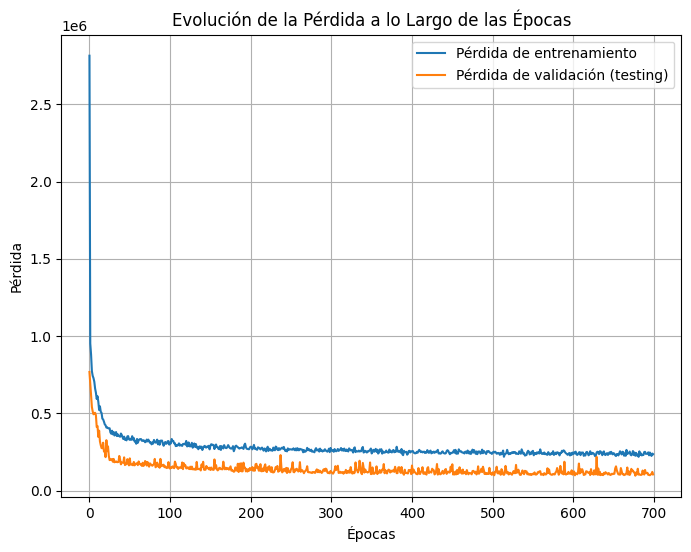

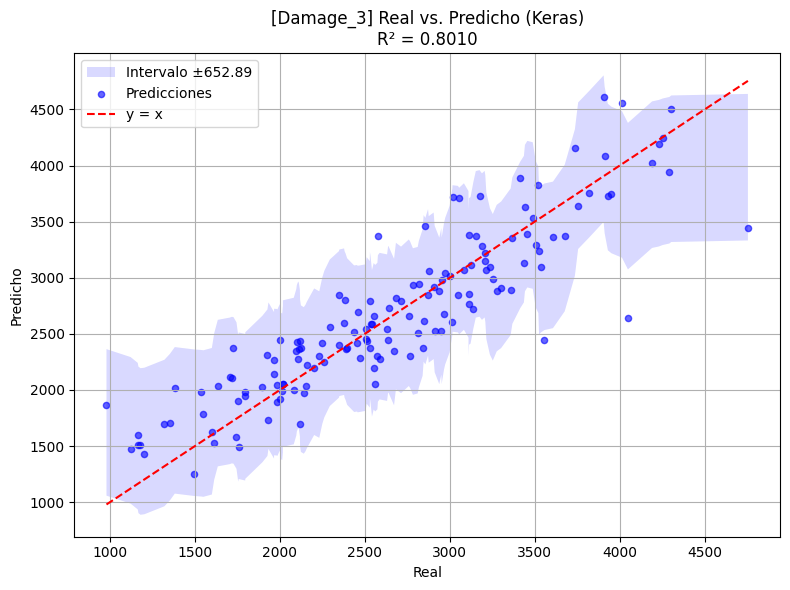

In [63]:
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2:.4f}")


# **Graficar la pérdida a través de las épocas**
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación (testing)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida a lo Largo de las Épocas')
plt.legend()
plt.grid(True)
plt.show()


# A) Real vs. Predicho (unfiltered)
plt.figure(figsize=(8, 6))
idx_unf = np.argsort(Y_valid.values)
X_real_unf = Y_valid.values[idx_unf]  # Real ordenado
Y_pred_unf = y_preds[idx_unf]         # Predicho ordenado

# Suavizado de la curva
window_size = 11  # Ajustar según datos (debe ser impar)
poly_order = 2
if len(Y_pred_unf) >= window_size:
    Y_pred_unf_smooth = savgol_filter(Y_pred_unf, window_length=window_size, polyorder=poly_order)
else:
    Y_pred_unf_smooth = Y_pred_unf

percentil_alto = np.percentile(np.abs(Y_valid - y_preds), 95)
Y_inf_unf_smooth = Y_pred_unf_smooth - percentil_alto
Y_sup_unf_smooth = Y_pred_unf_smooth + percentil_alto

plt.fill_between(
    X_real_unf,
    Y_inf_unf_smooth,
    Y_sup_unf_smooth,
    color='blue',
    alpha=0.15,
    edgecolor='none',
    linewidth=0,
    label=f'Intervalo ±{percentil_alto:.2f}'
)
plt.scatter(X_real_unf, Y_pred_unf, color='blue', alpha=0.6, s=20, label='Predicciones')

min_val = min(X_real_unf.min(), Y_pred_unf.min())
max_val = max(X_real_unf.max(), Y_pred_unf.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

plt.title(f"[Damage_3] Real vs. Predicho (Keras)\nR² = {r2:.4f}")
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.grid(True)
plt.legend()
plt.tight_layout()


Nuevo R² (error < 20%): 0.8728
Cantidad de valores con error < 20%: 124
Cantidad de valores con error >= 20%: 23


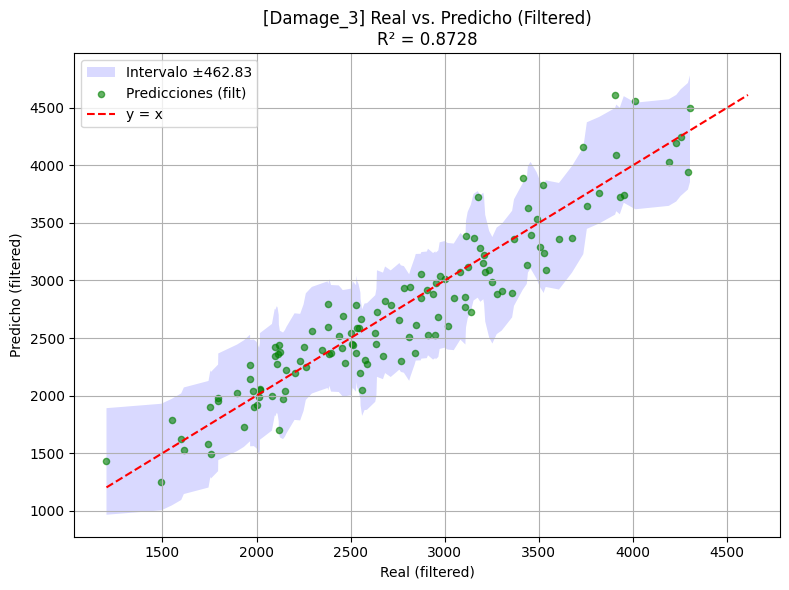

In [53]:
# Definir el valor del filtro de error porcentual
valor_filtro = 20

# Calcular el error porcentual
error_percentual = np.abs((Y_valid - y_preds) / Y_valid) * 100

# Filtrar los valores con un error menor al valor del filtro
indices_error_bajo = error_percentual[error_percentual < valor_filtro].index
Y_valid_error_bajo = Y_valid.loc[indices_error_bajo]
y_preds_error_bajo = y_preds[indices_error_bajo]

# Filtrar los valores con un error mayor o igual al valor del filtro
indices_error_alto = error_percentual[error_percentual >= valor_filtro].index
Y_valid_error_alto = Y_valid.loc[indices_error_alto]
y_preds_error_alto = y_preds[indices_error_alto]

# Calcular el nuevo R²
r2_error_bajo = r2_score(Y_valid_error_bajo, y_preds_error_bajo)
print(f"Nuevo R² (error < {valor_filtro}%): {r2_error_bajo:.4f}")

# Contar los valores
num_valores_bajo = len(indices_error_bajo)
num_valores_alto = len(indices_error_alto)
print(f"Cantidad de valores con error < {valor_filtro}%: {num_valores_bajo}")
print(f"Cantidad de valores con error >= {valor_filtro}%: {num_valores_alto}")

# Graficar los valores con error menor al valor del filtro


# B) Real vs. Predicho (filtered)
nuevo_percentil_alto = np.percentile(np.abs(Y_valid_error_bajo - y_preds_error_bajo), 95)
Y_valid_filtrados = Y_valid_error_bajo
y_preds_filtrados = y_preds_error_bajo

if len(Y_valid_filtrados) > 0:
    plt.figure(figsize=(8, 6))
    idx_filt = np.argsort(Y_valid_filtrados.values)
    X_real_filt = Y_valid_filtrados.values[idx_filt]
    Y_pred_filt = y_preds_filtrados[idx_filt]

    if len(Y_pred_filt) >= window_size:
        Y_pred_filt_smooth = savgol_filter(Y_pred_filt, window_size, poly_order)
    else:
        Y_pred_filt_smooth = Y_pred_filt

    if not np.isnan(nuevo_percentil_alto):
        Y_inf_filt_smooth = Y_pred_filt_smooth - nuevo_percentil_alto
        Y_sup_filt_smooth = Y_pred_filt_smooth + nuevo_percentil_alto
    else:
        Y_inf_filt_smooth = Y_pred_filt_smooth
        Y_sup_filt_smooth = Y_pred_filt_smooth

    plt.fill_between(
        X_real_filt,
        Y_inf_filt_smooth,
        Y_sup_filt_smooth,
        color='blue',
        alpha=0.15,
        edgecolor='none',
        linewidth=0,
        label=f'Intervalo ±{nuevo_percentil_alto:.2f}' if not np.isnan(nuevo_percentil_alto) else 'Intervalo'
    )
    plt.scatter(X_real_filt, Y_pred_filt, color='green', alpha=0.6, s=20, label='Predicciones (filt)')

    min_val_f = min(X_real_filt.min(), Y_pred_filt.min())
    max_val_f = max(X_real_filt.max(), Y_pred_filt.max())
    plt.plot([min_val_f, max_val_f], [min_val_f, max_val_f], 'r--', label='y = x')

    plt.title(f"[Damage_3] Real vs. Predicho (Filtered)\nR² = {r2_error_bajo:.4f}")
    plt.xlabel("Real (filtered)")
    plt.ylabel("Predicho (filtered)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

C:\Users\peped\AppData\Local\Temp\ipykernel_17560\1210647480.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_promedio_por_intervalo = error_percentual.groupby(Y_valid_binned).mean()


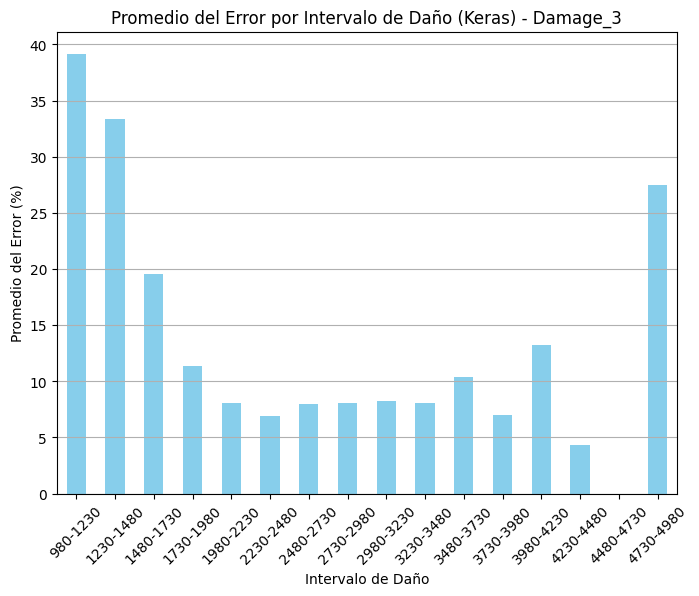

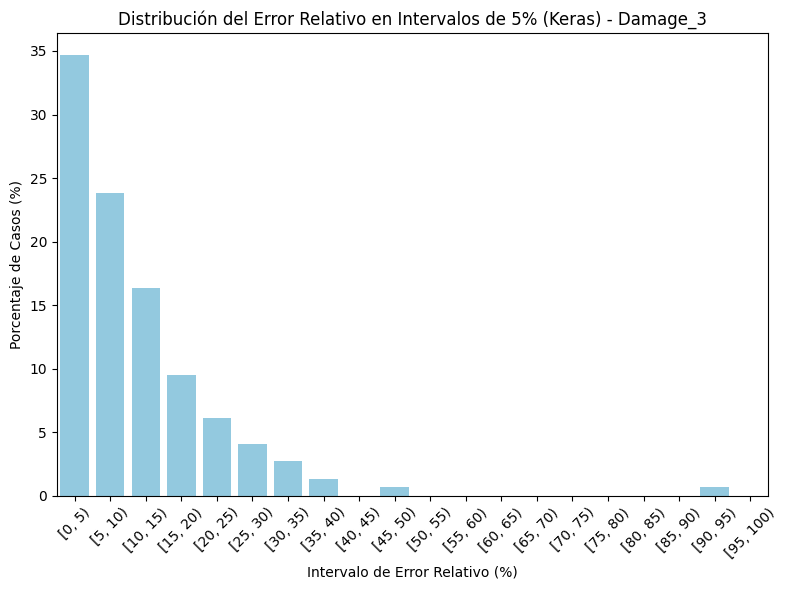

In [58]:
# Definir el valor del intervalo
valor_intervalo = 250

# Crear los intervalos de daño
bins = np.arange(Y_valid.min(), Y_valid.max() + valor_intervalo, valor_intervalo)
labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
Y_valid_binned = pd.cut(Y_valid, bins=bins, labels=labels, include_lowest=True)

# Calcular el promedio del error para cada intervalo
error_percentual = np.abs((Y_valid - y_preds) / Y_valid) * 100
error_promedio_por_intervalo = error_percentual.groupby(Y_valid_binned).mean()

# Crear la gráfica de barras
plt.figure(figsize=(8, 6))
error_promedio_por_intervalo.plot(kind='bar', color='skyblue')
plt.xlabel('Intervalo de Daño')
plt.ylabel('Promedio del Error (%)')
plt.title('Promedio del Error por Intervalo de Daño (Keras) - Damage_3')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# # Calcular el promedio del error para cada intervalo para los valores filtrados
# Y_valid_error_bajo_binned = pd.cut(Y_valid_error_bajo, bins=bins, labels=labels, include_lowest=True)
# error_promedio_por_intervalo_bajo = error_percentual[indices_error_bajo].groupby(Y_valid_error_bajo_binned).mean()

# # Crear la gráfica de barras para los valores filtrados
# plt.figure(figsize=(8, 6))
# error_promedio_por_intervalo_bajo.plot(kind='bar', color='skyblue')
# plt.xlabel('Intervalo de Daño')
# plt.ylabel('Promedio del Error (%)')
# plt.title(f'Promedio del Error por Intervalo de Daño (Error < {valor_filtro}%)')
# plt.xticks(rotation=45)
# plt.grid(axis='y')
# plt.show()


# --------------------------------------------------------------------
# 6. GRÁFICA DE BARRAS DE ERROR RELATIVO PARA DAMAGE_3
# --------------------------------------------------------------------
# Calcular el error relativo para cada predicción
error_relativo_damage_3 = np.abs((Y_valid - y_preds) / Y_valid) * 100

# Crear un DataFrame con los errores relativos
error_data_damage_3 = pd.DataFrame({
    "Error Relativo (%)": error_relativo_damage_3
})

# Agrupar los errores relativos en intervalos de 5%
bins = np.arange(0, 105, 5)
error_data_damage_3['Intervalo'] = pd.cut(error_data_damage_3["Error Relativo (%)"], bins, right=False)

# Contar la cantidad de casos en cada intervalo
error_counts_damage_3 = error_data_damage_3['Intervalo'].value_counts().sort_index()

# Calcular el porcentaje de casos en cada intervalo
error_percentages_damage_3 = (error_counts_damage_3 / len(error_data_damage_3)) * 100

# Crear la gráfica de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=error_percentages_damage_3.index.astype(str), y=error_percentages_damage_3.values, color="skyblue")
plt.xlabel("Intervalo de Error Relativo (%)")
plt.ylabel("Porcentaje de Casos (%)")
plt.title("Distribución del Error Relativo en Intervalos de 5% (Keras) - Damage_3")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Entrenamiento modelo para damage 4**

In [134]:
# **Dividir en X e Y para Damage_4**
Y_damage_4 = train_data.iloc[:, 21].astype(float)
Y_valid_damage_4 = valid_data.iloc[:, 21].astype(float)

# **Dividir en entrenamiento y prueba (80%-20%) para Damage_4**
X_train_damage_4, X_test_damage_4, Y_train_damage_4, Y_test_damage_4 = train_test_split(X, Y_damage_4, test_size=0.3, random_state=42)

# **Construcción de la Red Neuronal para Damage_4**
def build_model_damage_4():
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train_damage_4.shape[1],)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='linear')  # Salida para regresión
    ])
    model.compile(optimizer=Nadam(learning_rate=0.0014), loss='mse', metrics=['mae'])
    return model

# **Crear el modelo para Damage_4**
model_damage_4 = build_model_damage_4()

# **Entrenamiento para Damage_4**
history_damage_4 = model_damage_4.fit(
    X_train_damage_4, Y_train_damage_4,
    validation_data=(X_test_damage_4, Y_test_damage_4),
    epochs=300,
    batch_size=200,
    #callbacks=[early_stopping],
    verbose=1
)

# **Evaluación final para Damage_4**
y_preds_damage_4 = model_damage_4.predict(X_valid).flatten()
mae_damage_4 = mean_absolute_error(Y_valid_damage_4, y_preds_damage_4)
mse_damage_4 = mean_squared_error(Y_valid_damage_4, y_preds_damage_4)
rmse_damage_4 = np.sqrt(mse_damage_4)
r2_damage_4 = r2_score(Y_valid_damage_4, y_preds_damage_4)

print(f"MAE (Damage_4): {mae_damage_4}")
print(f"MSE (Damage_4): {mse_damage_4}")
print(f"RMSE (Damage_4): {rmse_damage_4}")
print(f"R² (Damage_4): {r2_damage_4:.4f}")

Epoch 1/300


c:\Users\peped\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 65520.7891 - mae: 208.5605 - val_loss: 22264.2793 - val_mae: 109.3664
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 23618.3711 - mae: 119.8586 - val_loss: 18280.6387 - val_mae: 101.9691
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 22506.3828 - mae: 117.3108 - val_loss: 19503.9922 - val_mae: 101.3195
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 23554.0664 - mae: 116.8238 - val_loss: 18201.9473 - val_mae: 98.9514
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 23180.3398 - mae: 116.8503 - val_loss: 17836.2090 - val_mae: 98.3892
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 19973.0781 - mae: 108.6999 - val_loss: 18674.5762 - val_mae: 99.0638
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 19861.5840 - mae: 109.5799 - val_loss: 17535.9980 - val_mae: 97.6935
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 20132.7832 - mae: 111.3126 - val_loss: 17712.8359 - val_mae: 

**Graficar resultados para Damage_4**

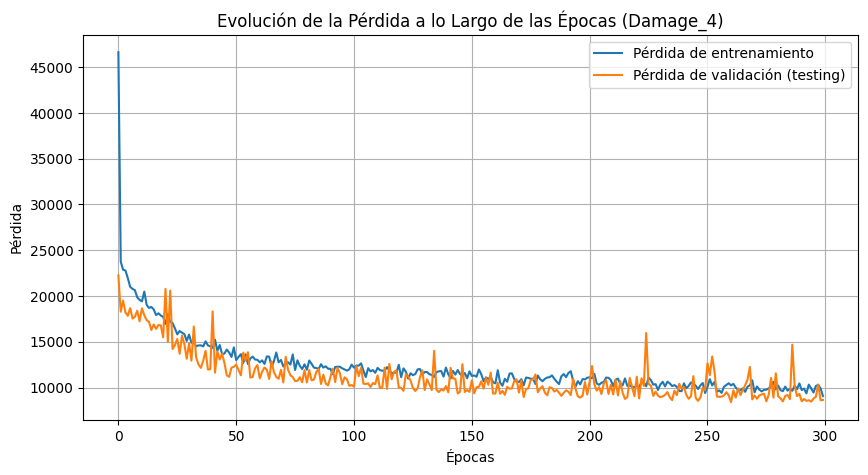

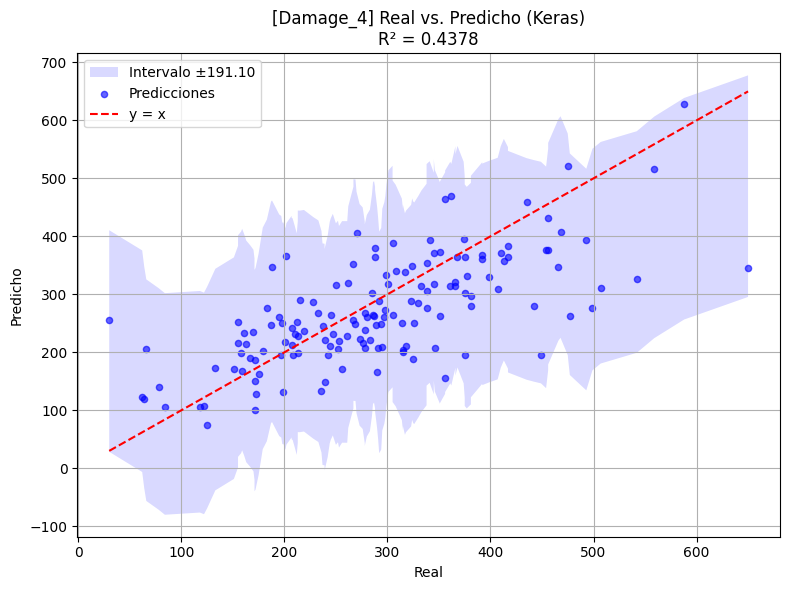

Nuevo R² (error < 20%): 0.8640
Cantidad de valores con error < 20%: 82
Cantidad de valores con error >= 20%: 65


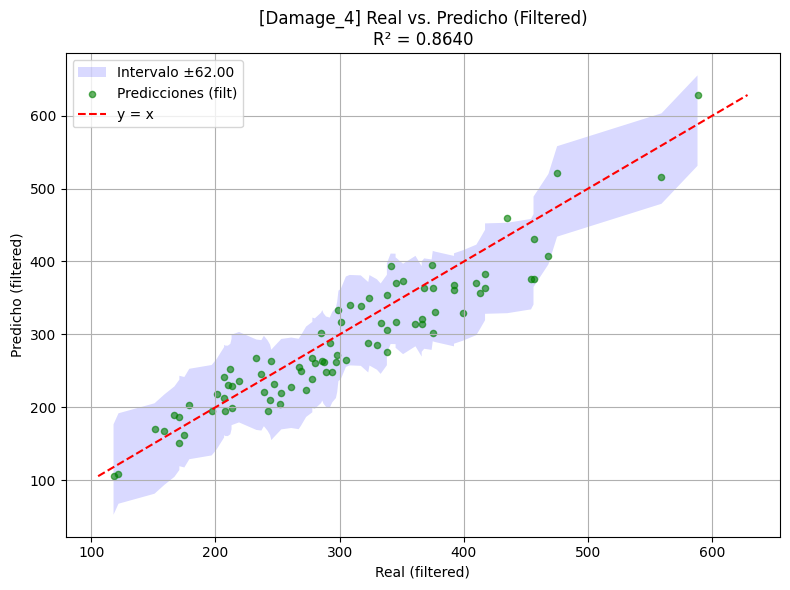

C:\Users\peped\AppData\Local\Temp\ipykernel_17560\2848991383.py:136: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_promedio_por_intervalo_damage_4 = error_percentual_damage_4.groupby(Y_valid_binned_damage_4).mean()


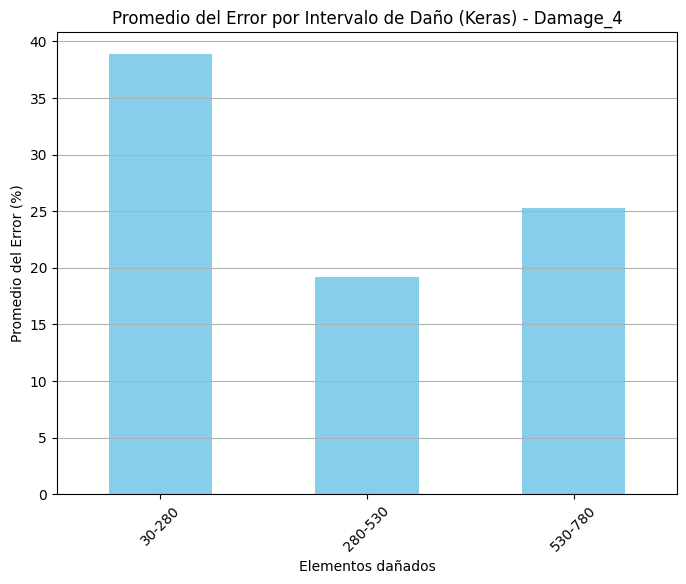

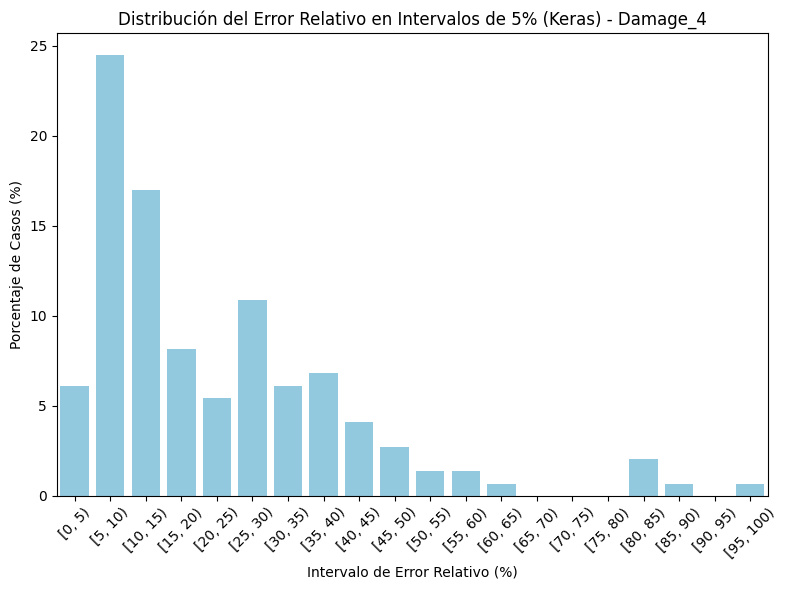

In [135]:

# **Graficar la pérdida a través de las épocas para Damage_4**
plt.figure(figsize=(10, 5))
plt.plot(history_damage_4.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history_damage_4.history['val_loss'], label='Pérdida de validación (testing)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida a lo Largo de las Épocas (Damage_4)')
plt.legend()
plt.grid(True)
plt.show()

# A) Real vs. Predicho (unfiltered) para Damage_4
plt.figure(figsize=(8, 6))
idx_unf_damage_4 = np.argsort(Y_valid_damage_4.values)
X_real_unf_damage_4 = Y_valid_damage_4.values[idx_unf_damage_4]  # Real ordenado
Y_pred_unf_damage_4 = y_preds_damage_4[idx_unf_damage_4]         # Predicho ordenado

# Suavizado de la curva
if len(Y_pred_unf_damage_4) >= window_size:
    Y_pred_unf_smooth_damage_4 = savgol_filter(Y_pred_unf_damage_4, window_length=window_size, polyorder=poly_order)
else:
    Y_pred_unf_smooth_damage_4 = Y_pred_unf_damage_4

percentil_alto_damage_4 = np.percentile(np.abs(Y_valid_damage_4 - y_preds_damage_4), 95)
Y_inf_unf_smooth_damage_4 = Y_pred_unf_smooth_damage_4 - percentil_alto_damage_4
Y_sup_unf_smooth_damage_4 = Y_pred_unf_smooth_damage_4 + percentil_alto_damage_4

plt.fill_between(
    X_real_unf_damage_4,
    Y_inf_unf_smooth_damage_4,
    Y_sup_unf_smooth_damage_4,
    color='blue',
    alpha=0.15,
    edgecolor='none',
    linewidth=0,
    label=f'Intervalo ±{percentil_alto_damage_4:.2f}'
)
plt.scatter(X_real_unf_damage_4, Y_pred_unf_damage_4, color='blue', alpha=0.6, s=20, label='Predicciones')

min_val_damage_4 = min(X_real_unf_damage_4.min(), Y_pred_unf_damage_4.min())
max_val_damage_4 = max(X_real_unf_damage_4.max(), Y_pred_unf_damage_4.max())
plt.plot([min_val_damage_4, max_val_damage_4], [min_val_damage_4, max_val_damage_4], 'r--', label='y = x')

plt.title(f"[Damage_4] Real vs. Predicho (Keras)\nR² = {r2_damage_4:.4f}")
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Definir el valor del filtro de error porcentual para Damage_4
valor_filtro_damage_4 = 20

# Calcular el error porcentual para Damage_4
error_percentual_damage_4 = np.abs((Y_valid_damage_4 - y_preds_damage_4) / Y_valid_damage_4) * 100

# Filtrar los valores con un error menor al valor del filtro para Damage_4
indices_error_bajo_damage_4 = error_percentual_damage_4[error_percentual_damage_4 < valor_filtro_damage_4].index
Y_valid_error_bajo_damage_4 = Y_valid_damage_4.loc[indices_error_bajo_damage_4]
y_preds_error_bajo_damage_4 = y_preds_damage_4[indices_error_bajo_damage_4]

# Filtrar los valores con un error mayor o igual al valor del filtro para Damage_4
indices_error_alto_damage_4 = error_percentual_damage_4[error_percentual_damage_4 >= valor_filtro_damage_4].index
Y_valid_error_alto_damage_4 = Y_valid_damage_4.loc[indices_error_alto_damage_4]
y_preds_error_alto_damage_4 = y_preds_damage_4[indices_error_alto_damage_4]

# Calcular el nuevo R² para Damage_4
r2_error_bajo_damage_4 = r2_score(Y_valid_error_bajo_damage_4, y_preds_error_bajo_damage_4)
print(f"Nuevo R² (error < {valor_filtro_damage_4}%): {r2_error_bajo_damage_4:.4f}")

# Contar los valores para Damage_4
num_valores_bajo_damage_4 = len(indices_error_bajo_damage_4)
num_valores_alto_damage_4 = len(indices_error_alto_damage_4)
print(f"Cantidad de valores con error < {valor_filtro_damage_4}%: {num_valores_bajo_damage_4}")
print(f"Cantidad de valores con error >= {valor_filtro_damage_4}%: {num_valores_alto_damage_4}")

# Graficar los valores con error menor al valor del filtro para Damage_4

# B) Real vs. Predicho (filtered) para Damage_4
nuevo_percentil_alto_damage_4 = np.percentile(np.abs(Y_valid_error_bajo_damage_4 - y_preds_error_bajo_damage_4), 95)
Y_valid_filtrados_damage_4 = Y_valid_error_bajo_damage_4
y_preds_filtrados_damage_4 = y_preds_error_bajo_damage_4

if len(Y_valid_filtrados_damage_4) > 0:
    plt.figure(figsize=(8, 6))
    idx_filt_damage_4 = np.argsort(Y_valid_filtrados_damage_4.values)
    X_real_filt_damage_4 = Y_valid_filtrados_damage_4.values[idx_filt_damage_4]
    Y_pred_filt_damage_4 = y_preds_filtrados_damage_4[idx_filt_damage_4]

    if len(Y_pred_filt_damage_4) >= window_size:
        Y_pred_filt_smooth_damage_4 = savgol_filter(Y_pred_filt_damage_4, window_size, poly_order)
    else:
        Y_pred_filt_smooth_damage_4 = Y_pred_filt_damage_4

    if not np.isnan(nuevo_percentil_alto_damage_4):
        Y_inf_filt_smooth_damage_4 = Y_pred_filt_smooth_damage_4 - nuevo_percentil_alto_damage_4
        Y_sup_filt_smooth_damage_4 = Y_pred_filt_smooth_damage_4 + nuevo_percentil_alto_damage_4
    else:
        Y_inf_filt_smooth_damage_4 = Y_pred_filt_smooth_damage_4
        Y_sup_filt_smooth_damage_4 = Y_pred_filt_smooth_damage_4

    plt.fill_between(
        X_real_filt_damage_4,
        Y_inf_filt_smooth_damage_4,
        Y_sup_filt_smooth_damage_4,
        color='blue',
        alpha=0.15,
        edgecolor='none',
        linewidth=0,
        label=f'Intervalo ±{nuevo_percentil_alto_damage_4:.2f}' if not np.isnan(nuevo_percentil_alto_damage_4) else 'Intervalo'
    )
    plt.scatter(X_real_filt_damage_4, Y_pred_filt_damage_4, color='green', alpha=0.6, s=20, label='Predicciones (filt)')

    min_val_f_damage_4 = min(X_real_filt_damage_4.min(), Y_pred_filt_damage_4.min())
    max_val_f_damage_4 = max(X_real_filt_damage_4.max(), Y_pred_filt_damage_4.max())
    plt.plot([min_val_f_damage_4, max_val_f_damage_4], [min_val_f_damage_4, max_val_f_damage_4], 'r--', label='y = x')

    plt.title(f"[Damage_4] Real vs. Predicho (Filtered)\nR² = {r2_error_bajo_damage_4:.4f}")
    plt.xlabel("Real (filtered)")
    plt.ylabel("Predicho (filtered)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Crear los intervalos de daño para Damage_4
bins_damage_4 = np.arange(Y_valid_damage_4.min(), Y_valid_damage_4.max() + valor_intervalo, valor_intervalo)
labels_damage_4 = [f"{int(bins_damage_4[i])}-{int(bins_damage_4[i+1])}" for i in range(len(bins_damage_4)-1)]
Y_valid_binned_damage_4 = pd.cut(Y_valid_damage_4, bins=bins_damage_4, labels=labels_damage_4, include_lowest=True)

# Calcular el promedio del error para cada intervalo para Damage_4
error_percentual_damage_4 = np.abs((Y_valid_damage_4 - y_preds_damage_4) / Y_valid_damage_4) * 100
error_promedio_por_intervalo_damage_4 = error_percentual_damage_4.groupby(Y_valid_binned_damage_4).mean()

# Crear la gráfica de barras para Damage_4
plt.figure(figsize=(8, 6))
error_promedio_por_intervalo_damage_4.plot(kind='bar', color='skyblue')
plt.xlabel('Elementos dañados')
plt.ylabel('Promedio del Error (%)')
plt.title('Promedio del Error por Intervalo de Daño (Keras) - Damage_4')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


# --------------------------------------------------------------------
# 6. GRÁFICA DE BARRAS DE ERROR RELATIVO PARA DAMAGE_4
# --------------------------------------------------------------------
# Calcular el error relativo para cada predicción
error_relativo_damage_4 = np.abs((Y_valid_damage_4 - y_preds_damage_4) / Y_valid_damage_4) * 100

# Crear un DataFrame con los errores relativos
error_data_damage_4 = pd.DataFrame({
    "Error Relativo (%)": error_relativo_damage_4
})

# Agrupar los errores relativos en intervalos de 5%
bins_damage_4 = np.arange(0, 105, 5)
error_data_damage_4['Intervalo'] = pd.cut(error_data_damage_4["Error Relativo (%)"], bins_damage_4, right=False)

# Contar la cantidad de casos en cada intervalo
error_counts_damage_4 = error_data_damage_4['Intervalo'].value_counts().sort_index()

# Calcular el porcentaje de casos en cada intervalo
error_percentages_damage_4 = (error_counts_damage_4 / len(error_data_damage_4)) * 100

# Crear la gráfica de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=error_percentages_damage_4.index.astype(str), y=error_percentages_damage_4.values, color="skyblue")
plt.xlabel("Intervalo de Error Relativo (%)")
plt.ylabel("Porcentaje de Casos (%)")
plt.title("Distribución del Error Relativo en Intervalos de 5% (Keras) - Damage_4")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()